In [29]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import matplotlib.dates as mdates
import os

In [30]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the base path to the desired directory on Google Drive
base_path = '/content/drive/MyDrive/Study_1_Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

In [32]:
def process_data(data, columns_to_remove):

    processed_data = data.drop(columns=columns_to_remove).values
    return processed_data

In [33]:
def construct_3d_array(base_dir, participants, simulations, columns_to_remove_hr, columns_to_remove_gsr, columns_to_remove_head, columns_to_remove_eye):
    """
    Construct 3D array from CSV files.
    """
    num_rows = 180  # Define number of rows to keep (last 180 rows)
    arrays_3d = []

    for participant in participants:
        participant_id = f"{int(participant):02d}"  # Format participant number to two digits

        valid_simulations = []

        for simulation in simulations:
            hr_file_path = os.path.join(base_dir, participant_id, simulation, f'HR{simulation.capitalize()}.csv')
            gsr_file_path = os.path.join(base_dir, participant_id, simulation, f'EDA{simulation.capitalize()}_downsampled.csv')
            head_file_path = os.path.join(base_dir, participant_id, simulation, 'head_tracking_downsampled.csv')
            eye_file_path = os.path.join(base_dir, participant_id, simulation, 'eye_tracking_downsampled.csv')

            # Check if all files exist
            if all(os.path.exists(file) for file in [hr_file_path, gsr_file_path, head_file_path, eye_file_path]):
                valid_simulations.append(simulation)

        num_valid_simulations = len(valid_simulations)
        if num_valid_simulations == 0:
            continue  # Skip this participant if no valid simulations are found

        array_3d = np.zeros((num_valid_simulations, num_rows, 47)) # hr=1, gsr=1, head=15-3, eye=41-8 total columns after removing columns= 48

        for s_idx, simulation in enumerate(valid_simulations):
            # Process hr data
            hr_file_path = os.path.join(base_dir, participant_id, simulation, f'HR{simulation.capitalize()}.csv')
            hr_data = read_csv(hr_file_path)
            processed_hr_data = process_data(hr_data, columns_to_remove_hr)
            processed_hr_data = processed_hr_data[-num_rows:]  # Keep only the last 180 rows

            # Process gsr data
            gsr_file_path = os.path.join(base_dir, participant_id, simulation, f'EDA{simulation.capitalize()}_downsampled.csv')
            gsr_data = read_csv(gsr_file_path)
            processed_gsr_data = process_data(gsr_data, columns_to_remove_gsr)
            processed_gsr_data = processed_gsr_data[-num_rows:]  # Keep only the last 180 rows

            # Process head data
            head_file_path = os.path.join(base_dir, participant_id, simulation, 'head_tracking_downsampled.csv')
            head_data = read_csv(head_file_path)
            processed_head_data = process_data(head_data, columns_to_remove_head)
            processed_head_data = processed_head_data[-num_rows:]  # Keep only the last 180 rows

            # Process eye data
            eye_file_path = os.path.join(base_dir, participant_id, simulation, 'eye_tracking_downsampled.csv')
            eye_data = read_csv(eye_file_path)
            processed_eye_data = process_data(eye_data, columns_to_remove_eye)
            processed_eye_data = processed_eye_data[-num_rows:]  # Keep only the last 180 rows

            # Combine processed data
            combined_data = np.concatenate((processed_hr_data, processed_gsr_data, processed_head_data, processed_eye_data), axis=1)

            array_3d[s_idx, :, :] = combined_data

        arrays_3d.append(array_3d)

    return arrays_3d


In [34]:
sample_size=60
# simulations_train = ['noise','bumps']
# simulations_test=['flat']
# val_indices = [4, 10, 11, 26, 28, 31, 33, 37] # for flat
# train_indices = [0, 1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 32, 34, 35, 36, 38, 39, 40, 41] # for flat


# simulations_test=['noise']
# simulations_train = ['flat','bumps']
# val_indices = [7, 15, 17, 19, 28, 31, 32, 42, 44, 48] # for noise
# train_indices = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47] # for noise

simulations_test=['bumps']
simulations_train = ['flat','noise']
val_indices = [1, 12, 16, 18, 22, 26, 28, 37, 41] # for speedbumps
train_indices = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 19, 20, 21, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44] # for speedbumps

In [35]:
participants = [str(i) for i in range(1, 27)]  # Participants 101 to 123
columns_to_remove_hr = []
columns_to_remove_gsr = []
columns_to_remove_eye = ['#Frame','Time', 'Unnamed: 40','ConvergenceValid','Left_Eye_Closed','Right_Eye_Closed','LocalGazeValid','WorldGazeValid']
columns_to_remove_head = ['#Frame','Time', 'Unnamed: 14']

In [36]:
arrays_train = construct_3d_array(base_path, participants, simulations_train, columns_to_remove_hr, columns_to_remove_gsr, columns_to_remove_head, columns_to_remove_eye)
arrays_test = construct_3d_array(base_path, participants, simulations_test, columns_to_remove_hr, columns_to_remove_gsr, columns_to_remove_head, columns_to_remove_eye)


In [37]:
# Concatenate arrays along the first axis
input_train = np.concatenate(arrays_train, axis=0)
input_test = np.concatenate(arrays_test, axis=0)

# Display the shape of the final concatenated 3D array
print(f"Shape of the final concatenated 3D array: {input_train.shape}")
print(f"Shape of the final concatenated 3D array: {input_test.shape}")

Shape of the final concatenated 3D array: (45, 180, 47)
Shape of the final concatenated 3D array: (23, 180, 47)


In [38]:
def calculate_total_ssq(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    n_columns = [0, 5, 6, 7, 8, 14, 15]
    o_columns = [0, 1, 2, 3, 4, 8, 10]
    d_columns = [4, 7, 9, 10, 11, 12, 13]

    # Calculate sum for each specified set of columns
    n_val = df.iloc[:, n_columns].sum(axis=1)
    o_val = df.iloc[:, o_columns].sum(axis=1)
    d_val = df.iloc[:, d_columns].sum(axis=1)

    return n_val,o_val,d_val

In [39]:
def merge_ssq_column(conditions,participants):
  directories = []
  total_ssq_values = []
  for participant in participants:
      participant = f"{int(participant):02d}"
      for condition in conditions:
          directory = os.path.join(base_path, participant, condition)
          directories.append(directory)

  # Loop through each directory
  for directory in directories:
      # Check if the directory exists
      if not os.path.exists(directory):
          continue

      # Get all CSV files in the directory that are named 'ssq.csv'
      csv_files = [file for file in os.listdir(directory) if file == 'ssq.csv']

      # Loop through each CSV file
      for csv_file in csv_files:
          csv_path = os.path.join(directory, csv_file)
          df = pd.read_csv(csv_path)
          n_val,o_val,d_val = calculate_total_ssq(csv_path)
          total_ssq_values.append([n_val, o_val, d_val])
          #ssq_values_participant = df.iloc[:, 0:17].values.flatten()   # Assuming SSQ values are in columns 1 to 16
          #total_ssq_values.append(ssq_values_participant)
  ssq_array = np.array(total_ssq_values)
  return ssq_array

def merge_total_ssq(conditions,participants):
  directories = []
  total_ssq_values = []
  for participant in participants:
      participant = f"{int(participant):02d}"
      for condition in conditions:
          directory = os.path.join(base_path, participant, condition)
          directories.append(directory)

  # Loop through each directory
  for directory in directories:
      # Check if the directory exists
      if not os.path.exists(directory):
          continue

      # Get all CSV files in the directory that are named 'ssq.csv'
      csv_files = [file for file in os.listdir(directory) if file == 'ssq.csv']

      # Loop through each CSV file
      for csv_file in csv_files:
          csv_path = os.path.join(directory, csv_file)
          n_val,o_val,d_val = calculate_total_ssq(csv_path)
          total_ssq = (n_val+o_val+d_val) * 3.74
          df = pd.read_csv(csv_path)
          df["total-ssq"] = total_ssq
          #print("csv_path: ",csv_path,"   ",total_ssq)
          total_ssq_values.append(total_ssq)
  # Create a DataFrame from the list of total SSQ values
  df_total_ssq = pd.DataFrame(total_ssq_values, columns=["total-ssq"])
  # Convert the list of total SSQ values to a NumPy array
  total_ssq_array = np.array(total_ssq_values)
  return total_ssq_array



In [40]:
output_train=merge_ssq_column(simulations_train,participants)
output_train = np.squeeze(output_train)
output_test=merge_ssq_column(simulations_test,participants)
output_test = np.squeeze(output_test)
output_train_total_ssq=merge_total_ssq(simulations_train,participants)
output_test_total_ssq=merge_total_ssq(simulations_test,participants)
output_train_total_ssq=output_train_total_ssq.reshape(-1, 1)
output_test_total_ssq=output_test_total_ssq.reshape(-1, 1)
print(output_train.shape,output_test.shape,output_train_total_ssq.shape,output_test_total_ssq.shape)

print(np.max(output_train, axis=0))
print("test")
print(np.max(output_test, axis=0))
# print(output_test)
# print(output_train_total_ssq)


(45, 3) (23, 3) (45, 1) (23, 1)
[20 15 18]
test
[13  9  9]


In [41]:
stacked_total_ssq = np.vstack((output_train_total_ssq, output_test_total_ssq))
print("stacked_output",stacked_total_ssq)
print(np.max(stacked_total_ssq, axis=0))

stacked_output [[  0.  ]
 [ 11.22]
 [ 11.22]
 [ 14.96]
 [  3.74]
 [  0.  ]
 [  3.74]
 [ 29.92]
 [ 29.92]
 [ 59.84]
 [  3.74]
 [ 26.18]
 [  0.  ]
 [ 14.96]
 [  0.  ]
 [ 22.44]
 [ 29.92]
 [ 11.22]
 [  0.  ]
 [  0.  ]
 [  3.74]
 [ 14.96]
 [ 14.96]
 [ 29.92]
 [ 14.96]
 [ 89.76]
 [198.22]
 [ 37.4 ]
 [  3.74]
 [ 18.7 ]
 [ 18.7 ]
 [ 56.1 ]
 [ 41.14]
 [ 18.7 ]
 [ 14.96]
 [ 29.92]
 [ 11.22]
 [ 22.44]
 [ 11.22]
 [ 26.18]
 [ 78.54]
 [ 67.32]
 [  0.  ]
 [  0.  ]
 [ 78.54]
 [  0.  ]
 [  7.48]
 [  0.  ]
 [ 37.4 ]
 [ 74.8 ]
 [  3.74]
 [ 26.18]
 [ 14.96]
 [ 14.96]
 [  0.  ]
 [ 29.92]
 [ 14.96]
 [ 52.36]
 [100.98]
 [ 33.66]
 [ 11.22]
 [ 44.88]
 [ 86.02]
 [ 14.96]
 [ 11.22]
 [ 74.8 ]
 [  0.  ]
 [ 71.06]]
[198.22]


In [42]:
import numpy as np
import matplotlib.pyplot as plt

def show_column_distribution(array, name):
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed

    num_columns = array.shape[1]  # Number of columns in the array

    # Plot the histograms for each column
    for i in range(num_columns):
        column = array[:, i]  # Get the column
        # Calculate the histogram of the column
        counts, bins = np.histogram(column, bins='auto')

        # Width of each bar
        width = bins[1] - bins[0]

        # Offset for positioning bars of different columns
        x_offset = i * width

        # Position for each bar
        x = bins[:-1] + x_offset

        # Plot the histogram with border for each column
        plt.bar(x, counts, width=width, edgecolor='black', linewidth=1, align='edge')

        # Add numerical data alongside the plot
        for j, count in enumerate(counts):
            plt.text(bins[j] + x_offset + width/2, count + 0.5, str(int(count)), ha='center', va='bottom')

    plt.xlabel('SSQ Value')  # Label for x-axis
    plt.ylabel('Number of data points')  # Label for y-axis
    #plt.title(f'Distribution of values for all columns in {name}')  # Title of the plot
    plt.legend()  # Show legend with labels

    plt.show()

# Example usage:
# array = np.random.randn(100, 4)  # Example array with 100 rows and 4 columns
# show_column_distribution(array, "Example Array")


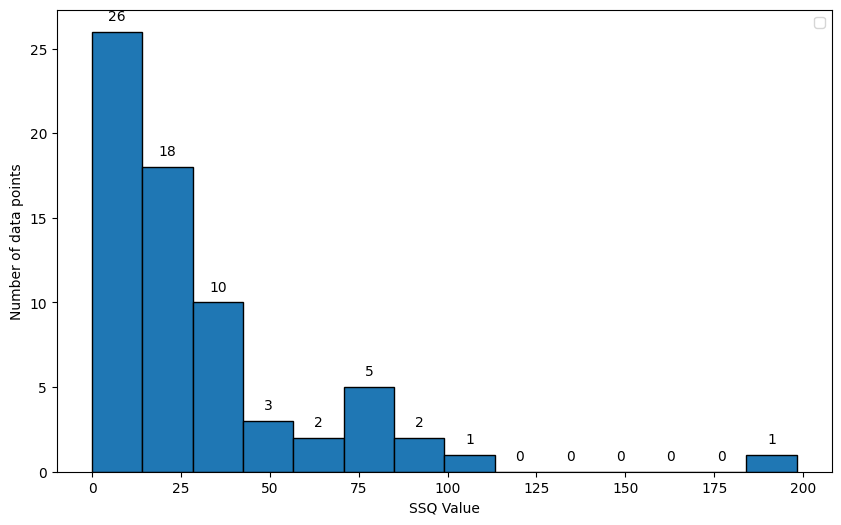

In [43]:
show_column_distribution(stacked_total_ssq,"SSQ distribution")

In [44]:

print(output_train.shape,output_test.shape)
stacked_3_subscales = np.vstack((output_train, output_test))
print("stacked_output",stacked_3_subscales.shape)

(45, 3) (23, 3)
stacked_output (68, 3)


In [45]:
import numpy as np
import matplotlib.pyplot as plt

def show_column_distribution(array, name):
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed

    num_columns = array.shape[1]  # Number of columns in the array
    colors = plt.cm.viridis(np.linspace(0, 1, num_columns))  # Generate distinct colors for each column

    # Define the bins based on the unique discrete values in the data
    min_value = np.min(array)
    max_value = np.max(array)
    bins = np.arange(start=min_value, stop=max_value + 2)  # Define bins to cover all discrete values
    column_labels = ['Nausea', 'Oculomotor', 'Disorientation']
    # Width of each bar (divided by the number of columns to prevent overlap)
    width = 0.8 / num_columns  # Adjust width to fit the bars within each unit interval

    # Plot the histograms for each column
    for i in range(num_columns):
        column = array[:, i]  # Get the column
        counts, bin_edges = np.histogram(column, bins=bins)

        # Offset each column's bars so they don't overlap
        x_offset = (i - (num_columns - 1) / 2) * width  # Center the bars around each x value

        # Position for each bar with the desired x-axis intervals
        x = bin_edges[:-1] + x_offset

        # Plot the histogram with distinct colors for each column
        plt.bar(x, counts, width=width, color=colors[i], edgecolor='black', linewidth=1,
                align='edge', label=column_labels[i])

        # Add numerical data above the bars if count > 0
        for j, count in enumerate(counts):
            if count > 0:  # Only show numbers where count is greater than 0
                plt.text(x[j] + width / 4, count + 0.5, str(int(count)), ha='center', va='bottom')

    plt.xlabel('Value')  # Label for x-axis
    plt.ylabel('Number of data points')  # Label for y-axis
    plt.title(f'{name}')  # Title of the plot

    # Set x-ticks to match the discrete values without altering them
    plt.xticks(np.arange(start=min_value, stop=max_value + 1))  # Discrete x-axis values

    plt.legend(title='Columns')  # Show legend with labels

    plt.show()




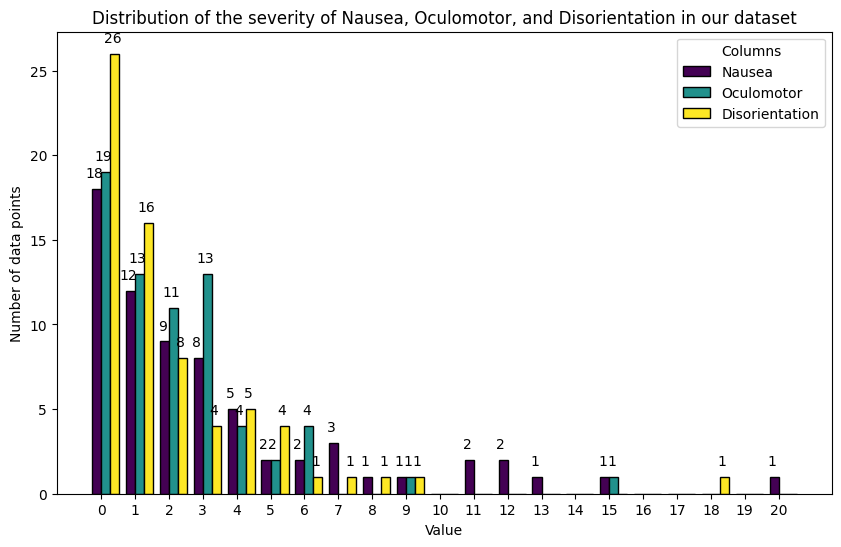

In [46]:
array = np.random.randn(68, 3)  # Example dataset with 68 rows and 3 columns
show_column_distribution(stacked_3_subscales, "Distribution of the severity of Nausea, Oculomotor, and Disorientation in our dataset")

In [47]:
import numpy as np
np.set_printoptions(precision=2)
from scipy.stats import spearmanr

stacked_data = np.vstack((output_train, output_test))

# Compute the Spearman correlation
corr, p_value = spearmanr(stacked_data, axis=0)
# Print the  correlation matrix
print("Pearson correlation matrix:")
print(corr)

# # Print the correlation matrix
# print("Spearman correlation matrix:")
# print(corr)
# print("P-values matrix:")
# print(p_value)
# # Compute the Pearson correlation
# corr = np.corrcoef(stacked_data, rowvar=False)




Pearson correlation matrix:
[[1.   0.73 0.74]
 [0.73 1.   0.74]
 [0.74 0.74 1.  ]]


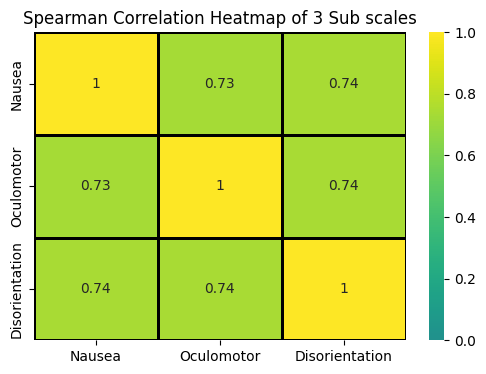

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
# Create a DataFrame from the correlation matrix
corr_df = pd.DataFrame(corr, columns=["Nausea", "Oculomotor", "Disorientation"], index=["Nausea", "Oculomotor", "Disorientation"])

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap='viridis', center=0, linewidths=1, linecolor='black',vmin=0)

# Add titles and labels
plt.title("Spearman Correlation Heatmap of 3 Sub scales")
plt.show()

In [49]:
# import numpy as np


# new_data = np.zeros((38, 3))

# # Assigning original serial numbers to the first column
# new_data[:, 0] = np.arange(1, 39)

# # Assigning original values to the second column
# new_data[:, 1] = output_train[:, 0]

# # Sorting the array based on the values (second column)
# sorted_indices = np.argsort(new_data[:, 1])
# sorted_data = new_data[sorted_indices]

# # Assigning new serial numbers to the third column
# current_val = sorted_data[0][1]
# start_idx = 0
# for i, row in enumerate(sorted_data):
#     if row[1] != current_val:
#         sorted_data[start_idx:i, 2] = np.arange(start_idx + 1, i + 1)
#         start_idx = i
#         current_val = row[1]

# # Assigning new serial numbers for the last group
# sorted_data[start_idx:, 2] = np.arange(start_idx + 1, len(sorted_data) + 1)

# #print(sorted_data)


In [50]:
def scale_input_data(input_train, input_test):
    # Get the shape of the input data
    num_samples_train, time_steps_train, num_features = input_train.shape
    num_samples_test, time_steps_test, _ = input_test.shape

    # Reshape the input data into 2D arrays
    flattened_train_data = input_train.reshape(-1, num_features)
    flattened_test_data = input_test.reshape(-1, num_features)

    # Initialize a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler on the training data and transform both train and test data
    scaled_train_data = scaler.fit_transform(flattened_train_data)
    scaled_test_data = scaler.transform(flattened_test_data)

    # Reshape the scaled data back to its original shape
    scaled_train_data = scaled_train_data.reshape(num_samples_train, time_steps_train, num_features)
    scaled_test_data = scaled_test_data.reshape(num_samples_test, time_steps_test, num_features)

    return scaled_train_data, scaled_test_data

def scale_target_var(target_data):
    min_val, max_val = np.min(target_data, axis=0), np.max(target_data, axis=0)
    target_data = (target_data-min_val)/(max_val-min_val)

    return target_data, min_val, max_val

In [51]:
input_train, input_test= scale_input_data(input_train[:, (60-sample_size):(180-sample_size), :], input_test[:,  (60-sample_size):(180-sample_size), :])
output_train, min_val, max_val = scale_target_var(output_train_total_ssq)

In [52]:

input_val = input_train[val_indices]
input_train = input_train[train_indices]
output_val = output_train[val_indices]
output_train = output_train[train_indices]

In [53]:
print("input_train :", input_train.shape)
print("output_train :", output_train.shape)
print("input_val :", input_val.shape)
print("output_val :", output_val.shape)
print("input_test :", input_test.shape)
print("output_test :", output_test.shape)

input_train : (36, 120, 47)
output_train : (36, 1)
input_val : (9, 120, 47)
output_val : (9, 1)
input_test : (23, 120, 47)
output_test : (23, 3)


In [54]:
from keras.layers import Input, LSTM, Dense, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
total_losses=[]
for iteration in range(5):
  def get_lstm(input_shape1, input_shape2):
      model = Sequential()
      model.add(LSTM(64, input_shape = (input_shape1, input_shape2), return_sequences=False))
      model.add(Dense(256, activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(1))
      return model


  # Assuming train_input, train_output, test_input, test_output are numpy arrays

  # Reshape train and test inputs to match LSTM input shape
  train_input_reshaped = input_train.reshape((input_train.shape[0], input_train.shape[1], input_train.shape[2]))
  test_input_reshaped = input_test.reshape((input_test.shape[0], input_test.shape[1], input_test.shape[2]))
  val_input_reshaped = input_val.reshape((input_val.shape[0], input_val.shape[1], input_val.shape[2]))

  # Get input and output layers for LSTM model
  model = get_lstm(input_train.shape[1], input_train.shape[2])
  model.compile(loss='mse', optimizer='adam')

  best_val=1000000;
  patience=0;
  best_model = None
  for k in range(200):
    model.fit(train_input_reshaped, output_train, epochs=1, batch_size=32)

    pred_val=model.predict(val_input_reshaped)
    pred_val = pred_val*(max_val-min_val) + min_val
    # Evaluate the model
    import sklearn
    loss = sklearn.metrics.mean_squared_error(pred_val, output_val, squared = False)
    if loss <= best_val:
        best_val = loss
        patience = 0
        best_model = model
    else:
        patience +=1
        if patience > 10:
            print("K:",k)
            break

  pred_test=best_model.predict(test_input_reshaped)
  pred_test = pred_test*(max_val-min_val) + min_val
  # Evaluate the model
  import sklearn
  loss = sklearn.metrics.mean_squared_error(pred_test, output_test_total_ssq, squared = False)
  print("Test Loss no ",iteration,":" ,loss)
  total_losses.append(loss)
average_loss = sum(total_losses) / len(total_losses)
total_losses.append(average_loss)
print("average_loss:",average_loss)
print(sample_size, simulations_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0243
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0202
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0106 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0159
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0268
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0210
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0070
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0240
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0668
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0241
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/ste